In [1]:
%matplotlib inline
import numpy as np
import math
from matplotlib import pyplot as plt

### Linear Regression Revisited

Let us consider the problem of findind a line that pass through the points.

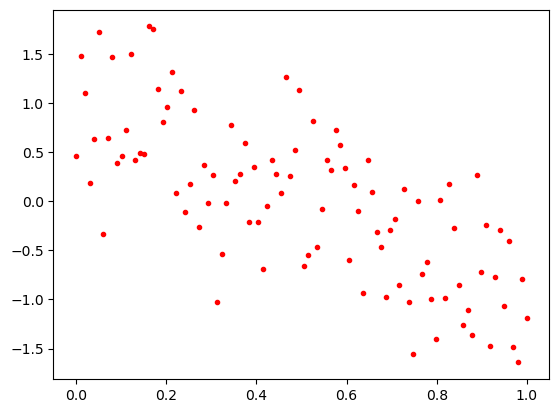

In [2]:
np.random.seed(123)
n = 100
dx = np.linspace(0,1,n)
dy = -2*dx + 1 + np.random.randn(n)/2
plt.plot(dx,dy,'.r')

1) What exactly are we trying to minimize and why?

We are trying to find a line $y = mx+c$ that best fits the data points. To do this, we need to minimize the error between the predicted values ($y_{pred} = mx_i+c$) and the actual values ($y_i$). A common choice for the error function is the **Mean Squared Error (MSE)**, which is the average of the squared differences between the predicted and actual values.

The function we want to minimize, called the cost function, is:
$$ J(m,c) = \frac{1}{N}\sum_{i=1}^N (y_i - (m x_i + c))^2 $$

We will use gradient descent to find the values of $m$ and $c$ that minimize this function.

2) Minimize and Visualize it.

Optimized parameters: m = -1.9859634821102534, c = 1.0065361812132596


Text(0.5, 1.0, 'Linear Regression using Gradient Descent')

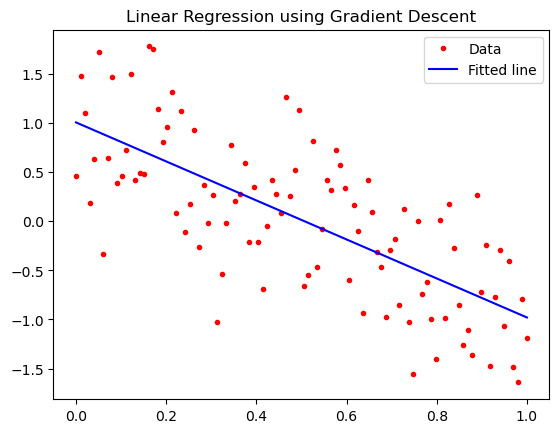

In [3]:
# solve using gradient descent

def loss_function(params, x, y):
    m, c = params
    y_pred = m * x + c
    return np.mean((y - y_pred) ** 2)

def gradient(params, x, y):
    m, c = params
    y_pred = m * x + c
    error = y - y_pred
    dm = -2 * np.mean(x * error)
    dc = -2 * np.mean(error)
    return np.array([dm, dc])

params = np.array([0.0, 0.0])  # initial guess for m and c
learning_rate = 0.1
n_iterations = 1000

for i in range(n_iterations):
    grads = gradient(params, dx, dy)
    params -= learning_rate * grads
m_opt, c_opt = params
print(f"Optimized parameters: m = {m_opt}, c = {c_opt}")
y_fit = m_opt * dx + c_opt
plt.plot(dx, dy, '.r', label='Data')
plt.plot(dx, y_fit, '-b', label='Fitted line')
plt.legend()
plt.title('Linear Regression using Gradient Descent')

Optimized m: -1.985966636594831
Optimized c: 1.0065378699930185


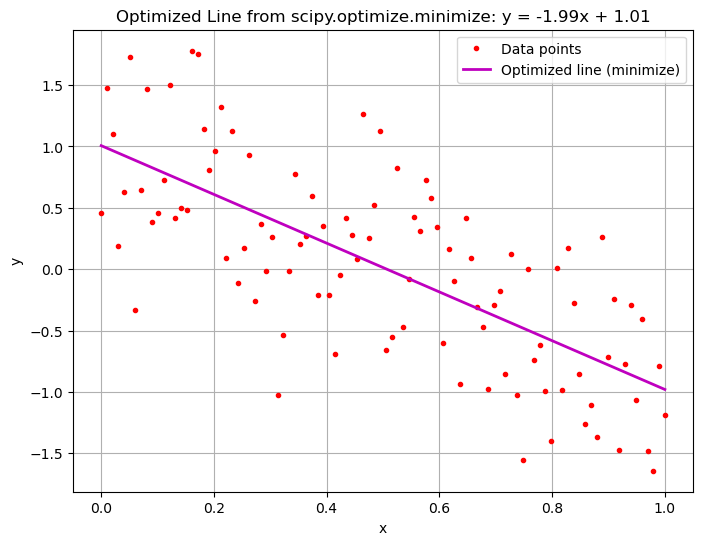

In [4]:
# solve using scipy.optimize.minimize

from scipy.optimize import minimize

# solve  --- IGNORE ---
initial_params = [0, 0]
result = minimize(loss_function, initial_params, args=(dx, dy))
optimized_m, optimized_c = result.x
print(f"Optimized m: {optimized_m}")
print(f"Optimized c: {optimized_c}")

# plot the result from scipy.optimize.minimize
plt.figure(figsize=(8, 6))
plt.plot(dx, dy, '.r', label='Data points')
x_line = np.linspace(0, 1, 100)
y_line = optimized_m * x_line + optimized_c
plt.plot(x_line, y_line, 'm-', linewidth=2, label='Optimized line (minimize)')
plt.title(f"Optimized Line from scipy.optimize.minimize: y = {optimized_m:.2f}x + {optimized_c:.2f}")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

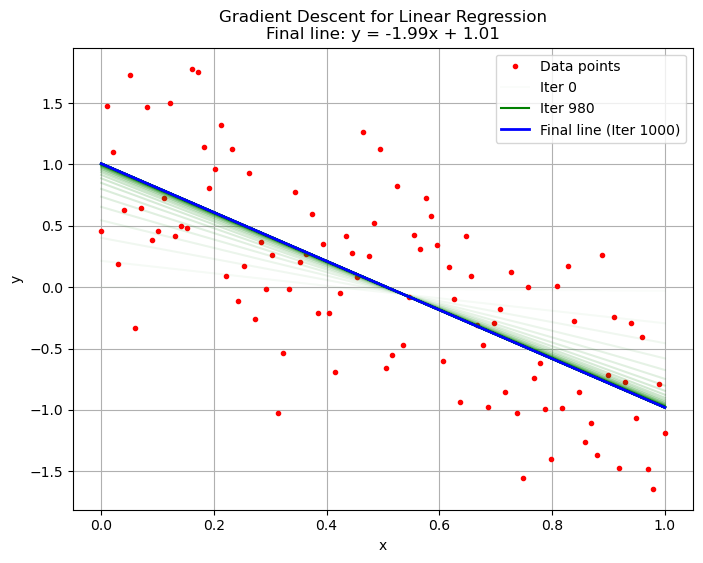

Final m: -1.9859634821102534
Final c: 1.0065361812132596


In [5]:
# Initial values
m = 0
c = 0

# Learning rate
alpha = 0.1

# Number of iterations
iterations = 1000

n_points = float(len(dx))

history = []

# Gradient Descent
for i in range(iterations):
    y_pred = m * dx + c
    # Calculate gradients
    D_m = (-2/n_points) * sum(dx * (dy - y_pred))
    D_c = (-2/n_points) * sum(dy - y_pred)
    # Update parameters
    m = m - alpha * D_m
    c = c - alpha * D_c
    
    if i % 20 == 0:
        history.append((m,c))

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(dx, dy, '.r', label='Data points')
x_line = np.linspace(0, 1, 100)

# Plot history of lines
for i, (m_h, c_h) in enumerate(history):
    y_line = m_h * x_line + c_h
    plt.plot(x_line, y_line, 'g-', alpha=(i+1)/len(history), label=f'Iter {i*20}' if i==0 or i==len(history)-1 else "")

# Plot final line
y_line = m * x_line + c
plt.plot(x_line, y_line, 'b-', linewidth=2, label=f'Final line (Iter {iterations})')
plt.title(f"Gradient Descent for Linear Regression\nFinal line: y = {m:.2f}x + {c:.2f}")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final m: {m}")
print(f"Final c: {c}")

### Separating Line.

We want to draw a separating line betwen two datasets shown below.

In [6]:
np.random.seed(234)
n1 = 100
n2 = 100
mean = [0, 0]
cov = [[1, -0.5], [-0.5, 1]]
r1, r2 = np.random.multivariate_normal(mean, cov, n1).T
#plt.plot(r1, r2, '.r')

mean = [2, 2]
cov = [[1, 0], [0, 1]]
b1, b2 = np.random.multivariate_normal(mean, cov, n2).T
#plt.plot(b1, b2, '.b')

colors = np.zeros(n1+n2)
colors[:n1] = 1.
colors[n1:] = 0.
#print colors

d = np.zeros((n1+n2,2))
d[:n1,0] = r1
d[:n1,1] = r2
d[n1:,0] = b1
d[n1:,1] = b2

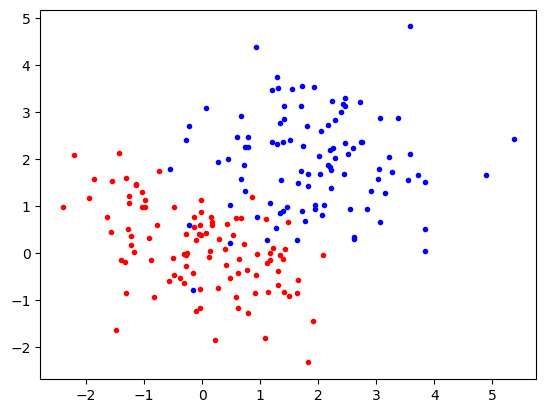

In [7]:
plt.plot(d[colors==1,0], d[colors==1,1],'.r')#note boolean indexing
plt.plot(d[colors==0,0], d[colors==0,1],'.b')#note boolean indexing

1) How can we model this as a optimization problem?


Optimized line parameters: m = -0.45194650645767254, c = 0.9472531769155381


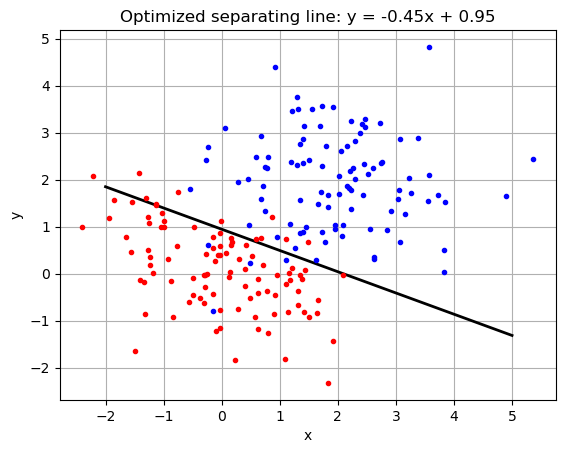

In [8]:
# create a function to penalize the dot when they are on the wrong side of the line

def penalize_wrong_side(x, y, color, m, c):
    if color == 1:  # red points should be below the line
        return y > (m * x + c)
    else:  # blue points should be above the line
        return y < (m * x + c)

def loss_function_line(params):
    m, c = params
    cost = 0
    for (x, y), color in zip(d, colors):
        if penalize_wrong_side(x, y, color, m, c):
            cost += (m * x + c - y) ** 2  # squared distance to the line
    return cost


m, c = minimize(loss_function_line, np.array([0, 0])).x
print(f"Optimized line parameters: m = {m}, c = {c}")
plt.plot(d[c==1,0], d[c==1,1],'.r')
plt.plot(d[c==0,0], d[c==0,1],'.b')
x_line = np.linspace(-2, 5, 100)
y_line = m * x_line + c
plt.plot(x_line, y_line, '-k', linewidth=2)
# plot data points
plt.plot(d[colors==1,0], d[colors==1,1],'.r')#note boolean indexing
plt.plot(d[colors==0,0], d[colors==0,1],'.b')#note boolean indexing
plt.title(f"Optimized separating line: y = {m:.2f}x + {c:.2f}")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()